In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from IPython import HTML

ImportError: cannot import name 'HTML' from 'IPython' (/Users/pranamshetty/Developer/Projects/TomatoSaviorAI/venv/lib/python3.11/site-packages/IPython/__init__.py)

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle=True,
    seed=32,

)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

1001

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[9 4 6 7 2 7 3 0 7 0 5 7 9 1 8 5]


2024-08-15 21:02:02.682395: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-08-15 21:02:06.136089: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


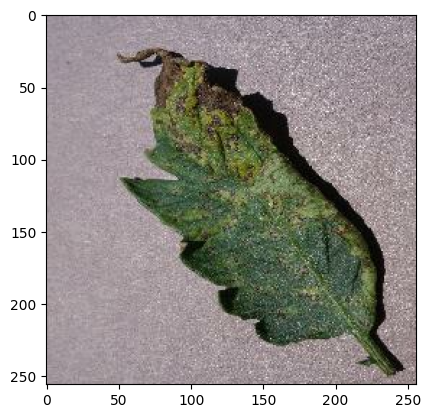

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [8]:
EPOCHS = 50


In [9]:
def get_partitioned_datasets(dataset, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=10)

    dataset_len = len(dataset)
    train_len = int( train_split * dataset_len)
    train_dataset = dataset.take(train_len)
    dataset = dataset.skip(train_len)

    val_len = int(val_split * dataset_len)
    val_dataset = dataset.take(val_len)
    dataset = dataset.skip(val_len)

    test_len = dataset_len - train_len - val_len
    test_dataset = dataset.take(test_len)

    return train_dataset, val_dataset, test_dataset

In [10]:
train_dataset, val_dataset, test_dataset = get_partitioned_datasets(dataset)

In [11]:
len(train_dataset)

800

In [12]:
len(val_dataset)

100

In [13]:
len(test_dataset)

101

In [14]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:


# resize_and_rescale = tf.keras.Sequential([
#     layers.Resizing(ONE_IMAGE_SIZE, ONE_IMAGE_SIZE),
#     layers.Rescaling(1.0/255)
# ])
class ResizeAndRescale(layers.Layer):
    def __init__(self, size):
        super().__init__()
        self.resize = layers.Resizing(size, size)
        self.rescale = layers.Rescaling( 1.0/255)
    def call(self, inputs):
        if tf.rank(inputs) == 5:
            shape = tf.rank(inputs)
            inputs = tf.reshape( inputs, [-1, shape[-3], shape [-2], shape [-1]])
        x=self.resize(inputs)
        return self.rescale(x)

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [31]:
CHANNELS = 3
ONE_IMAGE_SIZE=256
input_shape = (BATCH_SIZE, ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential ([
    layers.Input(shape=input_shape),
    ResizeAndRescale(ONE_IMAGE_SIZE),
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

# model.build(input_shape = input_shape)


/Users/pranamshetty/Developer/Projects/TomatoSaviorAI/venv/lib/python3.11/site-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'resize_and_rescale_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph,

OperatorNotAllowedInGraphError: Exception encountered when calling ResizeAndRescale.call().

[1mCould not automatically infer the output shape / dtype of 'resize_and_rescale_1' (of type ResizeAndRescale). Either the `ResizeAndRescale.call()` method is incorrect, or you need to implement the `ResizeAndRescale.compute_output_spec() / compute_output_shape()` method. Error encountered:

Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by ResizeAndRescale.call():
  • args=('<KerasTensor shape=(None, 16, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_12>',)
  • kwargs=<class 'inspect._empty'>